# Evaluate single site simulation

This script generates key information on forest structure, composition, demography and biophysical characteristics on a single site simulation

# Import modules

In [1]:
import sys

#Path to the esm_tools.py script
sys.path.append('/glade/u/home/adamhb/Earth-System-Model-Tools/process_output')

In [2]:
import os
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import xarray as xr
import functools
import cftime
import warnings
from matplotlib.dates import DateFormatter
import math
from datetime import datetime
import esm_tools
import esm_viz
import importlib
importlib.reload(esm_tools)
importlib.reload(esm_viz)

<module 'esm_viz' from '/glade/u/home/adamhb/Earth-System-Model-Tools/process_output/esm_viz.py'>

# Setup

In [88]:
save_processed_output = False
pft_names = ["pine","cedar","fir","shrub","oak"]
pft_colors = ['gold','darkorange','darkolivegreen','brown','springgreen']
n_pfts = len(pft_names)
years = list(range(1900, 1930))
last_five_years = list(range(2044, 2050))

case_name = "conifer-allom-090123_5pfts_-17e2acb6a_FATES-55794e61"
inst_tag = "0007"

# Root path where case output lives
model_output_root = '/glade/scratch/adamhb/archive'
# Path to put processed output
processed_output_root = '/glade/scratch/adamhb/processed_output'
output_path_for_case = os.path.join(processed_output_root,case_name,inst_tag)

if save_processed_output == True:
        # Path to store processed output (figs, tables etc.)
        esm_tools.create_directory(output_path_for_case)

# Constants
s_per_yr = 31536000
s_per_day = 3600 * 24
m2_per_ha = 1e4
m2_per_km2 = 1e6
g_per_kg = 1000
mm_per_m = 1000
months_per_yr = 12
s_per_month = 3600 * 24 * 30.4
W_per_kW = 1000

# History variables

In [4]:
# define the history variables to read in
fields = [
          #have on to import these dimensions
          'FATES_SEED_PROD_USTORY_SZ',
          'FATES_VEGC_AP',
          #patches and cohorts
          'FATES_NPATCHES',
          'FATES_PATCHAREA_AP','FATES_CANOPYAREA_AP',
          'FATES_NCOHORTS','FATES_NPATCH_AP',
          #structure
          #'FATES_LAI_AP',
          #density
          'FATES_NPLANT_PF',
          'FATES_NPLANT_SZAPPF',
          'FATES_NPLANT_SZPF',
          'FATES_NPLANT_ACPF',
          'FATES_NPLANT_CANOPY_SZPF',
          'FATES_NPLANT_USTORY_SZPF',
          #basal area
          'FATES_BASALAREA_SZPF',
          #crown_area
          'FATES_CANOPYCROWNAREA_PF',
          'FATES_CANOPYCROWNAREA_APPF',
          'FATES_CROWNAREA_APPF',
          'FATES_CANOPYAREA_HT',
          #'FATES_CROWNAREA_CLLL',
          'FATES_CROWNAREA_PF',
          #biomass
          'FATES_VEGC_PF','FATES_VEGC_AP','FATES_VEGC_ABOVEGROUND','FATES_VEGC_ABOVEGROUND_SZPF',
          #growth
          'FATES_DDBH_SZPF',
          #'FATES_DDBH_CANOPY_SZAP','FATES_DDBH_USTORY_SZAP',
          #mortality
          'FATES_MORTALITY_PF',
          #'FATES_MORTALITY_CANOPY_SZAP','FATES_MORTALITY_USTORY_SZAP',
          'FATES_MORTALITY_BACKGROUND_SZPF','FATES_MORTALITY_HYDRAULIC_SZPF','FATES_MORTALITY_CSTARV_SZPF',
          #'FATES_MORTALITY_IMPACT_SZPF',
          'FATES_MORTALITY_FIRE_SZPF','FATES_MORTALITY_CROWNSCORCH_SZPF',
          #'FATES_MORTALITY_CANOPY_SZ','FATES_MORTALITY_USTORY_SZ',
          'FATES_MORTALITY_SENESCENCE_SZPF',
          #seed production and recruitment
          #'FATES_SEED_PROD_USTORY_SZ','FATES_SEED_PROD_CANOPY_SZ',
          'FATES_SEEDS_IN',
          'FATES_SEED_BANK',
          'FATES_SEEDBANK_PF',
          'FATES_SEED_ALLOC_SZPF',
          'FATES_RECRUITMENT_PF',
          #GPP and NPP
          #'FATES_GPP','FATES_GPP_SZPF',
          'FATES_NPP_PF','FATES_NPP_SZPF',
          'FATES_AUTORESP_SZPF','FATES_MAINTAR_SZPF',
          #physical environment
          #Light
          'FATES_LAISUN_Z_CLLL','FATES_LAISHA_Z_CLLL',
          'FATES_LAISUN_Z_CLLLPF','FATES_LAISHA_Z_CLLLPF',
          'FATES_PARSUN_Z_CLLLPF','FATES_PARSHA_Z_CLLLPF',
          'FATES_PARPROF_DIR_CLLL','FATES_PARPROF_DIF_CLLL',
          'FATES_PARPROF_DIF_CLLLPF','FATES_PARPROF_DIR_CLLLPF',
          #Litter
          'FATES_CWD_ABOVEGROUND_DC',
          'FATES_FUEL_AMOUNT',
          #CLM
          'QVEGT','QVEGE','QSOIL','TLAI','TBOT','RAIN','QBOT','Q2M',
          #'BTRAN',
          #H20
          'SMP',
          #allocation
          #'FATES_STOREC_CANOPY_SZPF','FATES_STOREC_USTORY_SZPF',
          #fire
          'FATES_BURNFRAC','FATES_IGNITIONS','FATES_FIRE_INTENSITY_BURNFRAC',
          'FATES_FUEL_BULKD','FATES_FUEL_SAV',
           'FATES_DISTURBANCE_RATE_FIRE',
           'FATES_FUEL_AMOUNT_AP',
           'FATES_FIRE_INTENSITY_BURNFRAC_AP',
           'FATES_BURNFRAC_AP',
           'FATES_FUEL_AMOUNT_APFC',
           'FATES_FUEL_AMOUNT',
           'FATES_FDI',
           'FATES_FIRE_INTENSITY',
           'FATES_FUELCONSUMED',
           'FATES_NESTEROV_INDEX',
           'FATES_MORTALITY_CROWNSCORCH_SZPF',
           'FATES_SCORCH_HEIGHT_APPF','FATES_FUEL_MEF',
           'FATES_FUEL_EFF_MOIST','FATES_FUEL_MOISTURE_FC','FATES_ROS'
          # 'FATES_MORTALITY_FIRE_CFLUX_PF'
          ]

# Load data

In [75]:
ds_end = esm_tools.load_fates_output_data(model_output_root=model_output_root,
                            case_name = case_name,
                            years = last_five_years,
                            fields = fields,
                            inst_tag = inst_tag)

-- your data have been read in -- 


# Analyze final five years of simulation

## AGB

In [28]:
print("Total AGB [kg C m-2]:",esm_tools.get_AGB(ds_end))

Total AGB [kg C m-2]: 5.97377347946167


In [12]:
importlib.reload(esm_tools)
importlib.reload(esm_viz)

<module 'esm_viz' from '/glade/u/home/adamhb/Earth-System-Model-Tools/process_output/esm_viz.py'>

AGB units: kg m-2


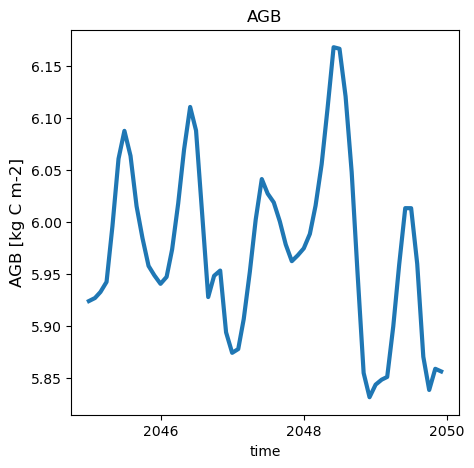

In [29]:
print("AGB units:",ds_end.FATES_VEGC_ABOVEGROUND.attrs['units'])

esm_viz.plot_array(ds_end.FATES_VEGC_ABOVEGROUND,
           xds = ds,
           n_pfts = n_pfts,
           title = "AGB",
           ylabel = "AGB [kg C m-2]",
           pft_colors = pft_colors,
           pft_names = pft_names,
           output_path = output_path_for_case,
           conversion = 1,
           subplots = False,
           getData = False,
           dbh_min = None)

## Canopy Height

In [53]:
ds_end

<xarray.Dataset>
Dimensions:                           (time: 60, fates_levscls: 13,
                                       fates_levage: 7, fates_levpft: 5,
                                       fates_levscagpf: 455, fates_levscpf: 65,
                                       fates_levcapf: 10, fates_levagepft: 35,
                                       fates_levheight: 6, fates_levcnlf: 60,
                                       fates_levcnlfpf: 300, fates_levcwdsc: 4,
                                       levgrnd: 25, fates_levagefuel: 42,
                                       fates_levfuel: 6)
Coordinates:
  * levgrnd                           (levgrnd) float32 0.01 0.04 ... 28.87 42.0
  * fates_levscls                     (fates_levscls) float32 0.0 5.0 ... 100.0
  * fates_levage                      (fates_levage) float32 0.0 1.0 ... 50.0
  * fates_levheight                   (fates_levheight) float32 0.0 0.1 ... 10.0
  * fates_levpft                      (fates_levpft) int32 1 2 3 4 5
  * fates_levfuel                     (fates_levfuel) int32 1 2 3 4 5 6
  * fates_levcwdsc                    (fates_levcwdsc) int32 1 2 3 4
  * time                              (time) object 2045-01-01 00:00:00 ... 2...
Dimensions without coordinates: fates_levscagpf, fates_levscpf, fates_levcapf,
                                fates_levagepft, fates_levcnlf,
                                fates_levcnlfpf, fates_levagefuel
Data variables: (12/79)
    FATES_SEED_PROD_USTORY_SZ         (time, fates_levscls) float32 dask.array<chunksize=(1, 13), meta=np.ndarray>
    FATES_VEGC_AP                     (time, fates_levage) float32 dask.array<chunksize=(1, 7), meta=np.ndarray>
    FATES_NPATCHES                    (time) float32 dask.array<chunksize=(1,), meta=np.ndarray>
    FATES_PATCHAREA_AP                (time, fates_levage) float32 dask.array<chunksize=(1, 7), meta=np.ndarray>
    FATES_CANOPYAREA_AP               (time, fates_levage) float32 dask.array<chunksize=(1, 7), meta=np.ndarray>
    FATES_NCOHORTS                    (time) float32 dask.array<chunksize=(1,), meta=np.ndarray>
    ...                                ...
    FATES_NESTEROV_INDEX              (time) float32 dask.array<chunksize=(1,), meta=np.ndarray>
    FATES_SCORCH_HEIGHT_APPF          (time, fates_levagepft) float32 dask.array<chunksize=(1, 35), meta=np.ndarray>
    FATES_FUEL_MEF                    (time) float32 dask.array<chunksize=(1,), meta=np.ndarray>
    FATES_FUEL_EFF_MOIST              (time) float32 dask.array<chunksize=(1,), meta=np.ndarray>
    FATES_FUEL_MOISTURE_FC            (time, fates_levfuel) float32 dask.array<chunksize=(1, 6), meta=np.ndarray>
    FATES_ROS                         (time) float32 dask.array<chunksize=(1,), meta=np.ndarray>
Attributes: (12/37)
    title:                                CLM History file information
    comment:                              NOTE: None of the variables are wei...
    Conventions:                          CF-1.0
    history:                              created on 09/06/23 04:46:24
    source:                               Community Terrestrial Systems Model
    hostname:                             cheyenne
    ...                                   ...
    ctype_urban_shadewall:                73
    ctype_urban_impervious_road:          74
    ctype_urban_pervious_road:            75
    time_period_freq:                     month_1
    Time_constant_3Dvars_filename:        ./conifer-allom-090123_5pfts_-17e2a...
    Time_constant_3Dvars:                 ZSOI:DZSOI:WATSAT:SUCSAT:BSW:HKSAT:...

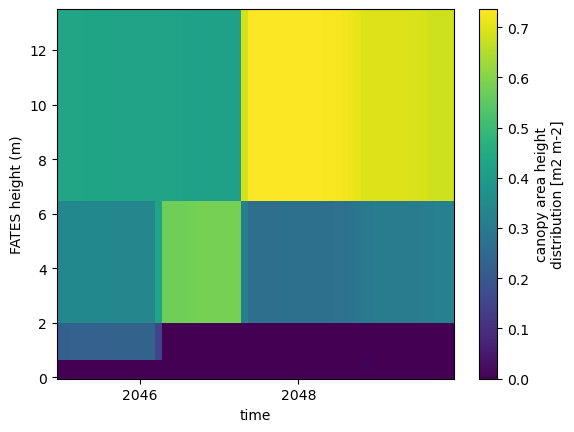

In [52]:
ds_end.FATES_CANOPYAREA_HT.plot(x = "time")

## Basal Area

In [30]:
print("Total basal area [m2 ha-1]:",np.sum(esm_tools.get_pft_level_basal_area(ds_end)))

Total basal area [m2 ha-1]: 15.564186


In [23]:
importlib.reload(esm_tools)
importlib.reload(esm_viz)

<module 'esm_viz' from '/glade/u/home/adamhb/Earth-System-Model-Tools/process_output/esm_viz.py'>

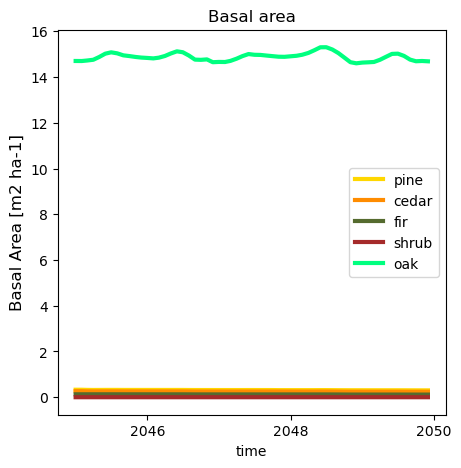

In [31]:
esm_viz.plot_array(ds_end.FATES_BASALAREA_SZPF,
           xds = ds_final_year,
           n_pfts = n_pfts,
           pft_colors = pft_colors,
           pft_names = pft_names,
           conversion = m2_per_ha,
           title = "Basal area",
           ylabel = "Basal Area [m2 ha-1]",
           output_path = output_path_for_case,
           subplots = False,
           getData = False,
           dbh_min = None)

### BA across size classes

In [26]:
importlib.reload(esm_tools)
importlib.reload(esm_viz)

<module 'esm_viz' from '/glade/u/home/adamhb/Earth-System-Model-Tools/process_output/esm_viz.py'>

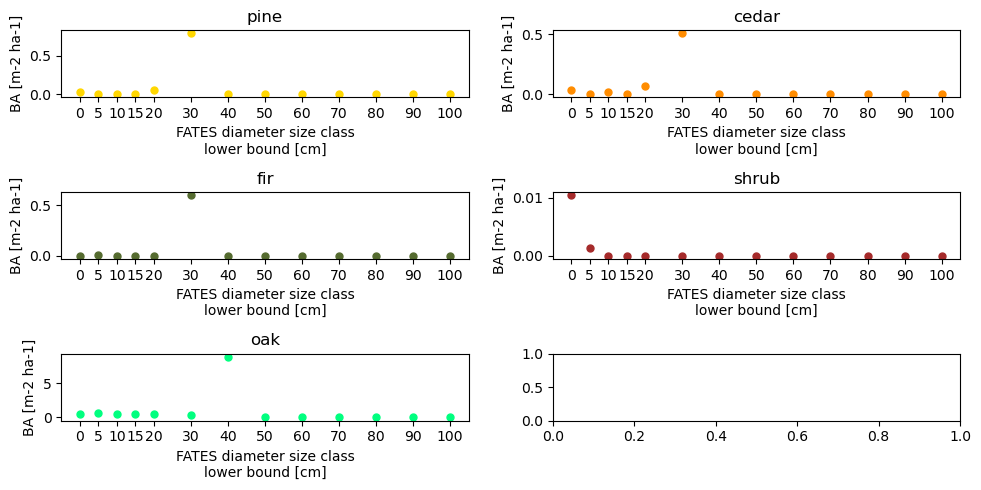

In [17]:
esm_viz.plot_size_class_distribution(ds_end,
                             n_pfts,
                             pft_colors = pft_colors,
                             pft_names = pft_names,
                             variable_type = "BA",
                             final_timestep = True,
                             specific_time_step = None,
                             conversion=m2_per_ha)

## Stem density

In [33]:
importlib.reload(esm_tools)
importlib.reload(esm_viz)

<module 'esm_viz' from '/glade/u/home/adamhb/Earth-System-Model-Tools/process_output/esm_viz.py'>

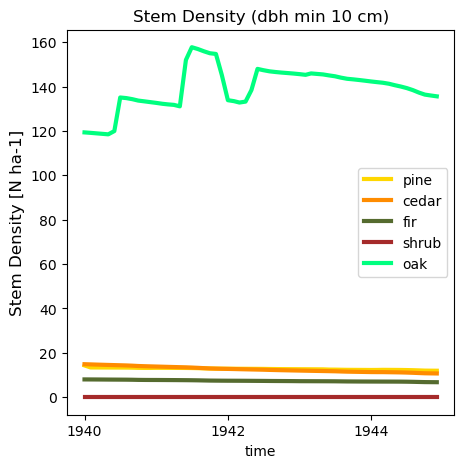

In [18]:
esm_viz.plot_array(ds_end.FATES_NPLANT_SZPF,
           xds = ds,
           n_pfts = n_pfts,
           pft_colors = pft_colors,
           pft_names = pft_names,
           title = "Stem Density" + " (dbh min " + str(10) + " cm)",
           ylabel = "Stem Density [N ha-1]",
           output_path = output_path_for_case,
           conversion = m2_per_ha,
           subplots = False,
           getData = False,
           dbh_min = 10)

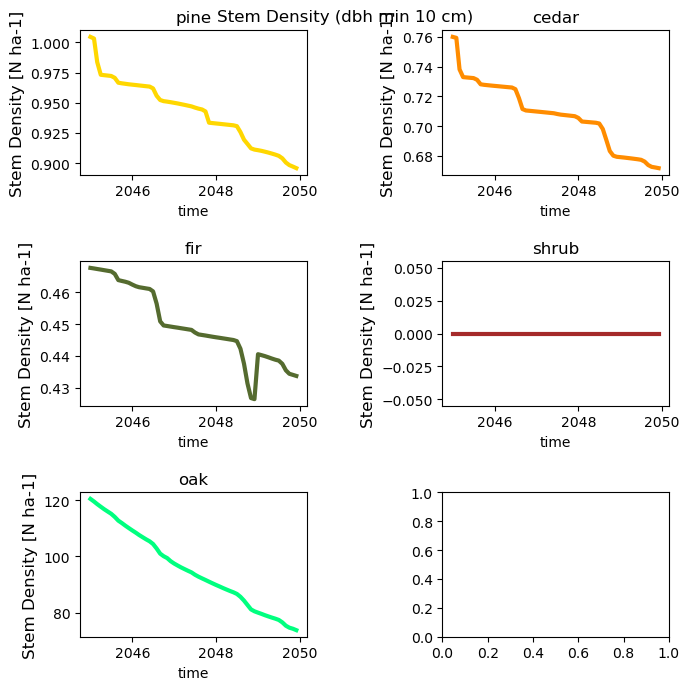

In [34]:
esm_viz.plot_array(ds_end.FATES_NPLANT_SZPF,
           xds = ds,
           n_pfts = n_pfts,
           pft_colors = pft_colors,
           pft_names = pft_names,
           title = "Stem Density" + " (dbh min " + str(10) + " cm)",
           ylabel = "Stem Density [N ha-1]",
           output_path = output_path_for_case,
           conversion = m2_per_ha,
           subplots = True,
           getData = False,
           dbh_min = 10)

### Stem density across size classes (dbh min = 10 cm)

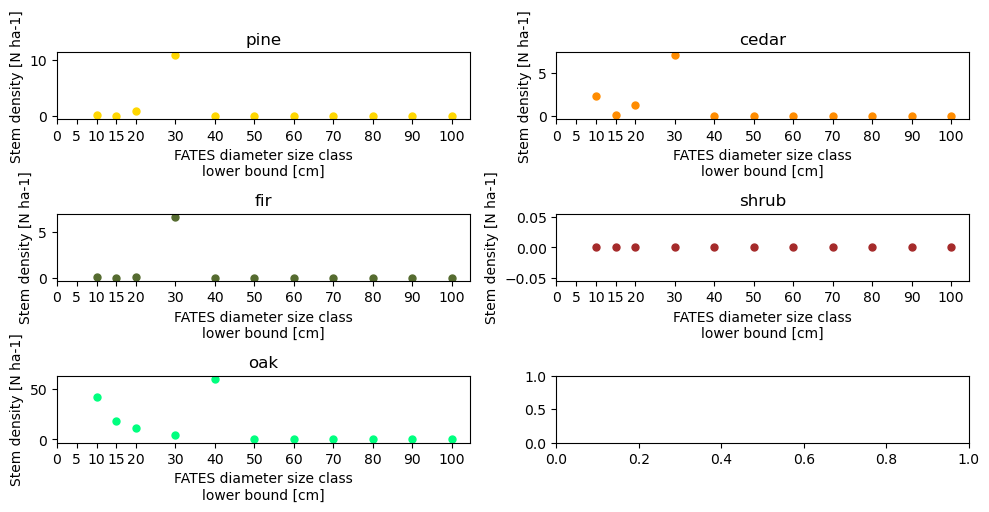

In [19]:
esm_viz.plot_size_class_distribution(ds_end,
                             n_pfts,
                             pft_colors = pft_colors,
                             pft_names = pft_names,
                             variable_type = "Stem density",
                             final_timestep = True,
                             specific_time_step = None,
                             conversion=m2_per_ha, dbh_min = 10)

## Crown area

### Canopy crown area

Text(0.5, 0, 'year')

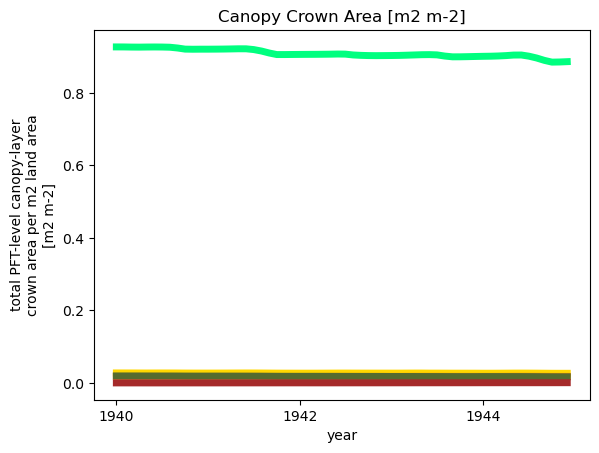

In [20]:
for p in range(n_pfts):
    ds_end.FATES_CANOPYCROWNAREA_PF.isel(fates_levpft=p).plot(color = pft_colors[p], linewidth = 5)
    
plt.title("Canopy Crown Area [m2 m-2]")
plt.xlabel("year")

### Crown area (canopy and understory)

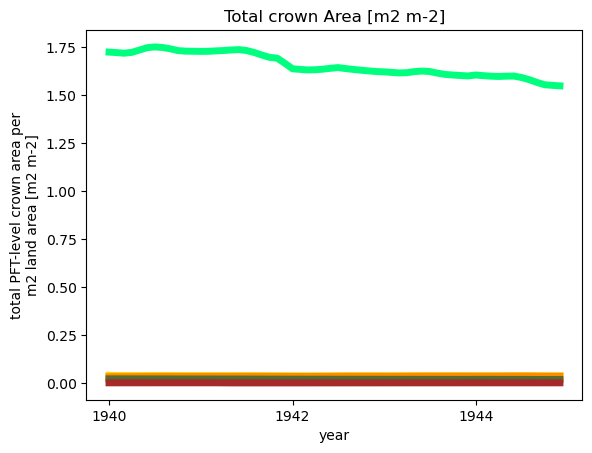

In [22]:
for p in range(n_pfts):
    ds_end.FATES_CROWNAREA_PF.isel(fates_levpft=p).plot(color = pft_colors[p], linewidth = 5)
    
plt.title("Total crown area [m2 m-2]")
plt.xlabel("year")
plt.show()

### Fraction of total crown area in canopy

Text(0.5, 0, 'year')

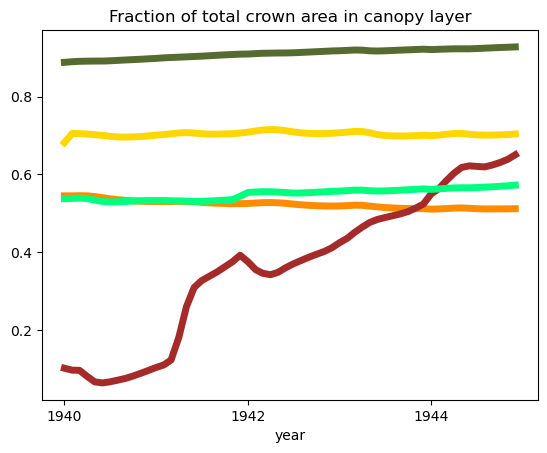

In [23]:
frac_in_canopy = esm_tools.frac_in_canopy(ds_end)
for p in range(n_pfts):
    frac_in_canopy.isel(fates_levpft=p).plot(color = pft_colors[p], linewidth = 5)
    
plt.title("Fraction of total crown area in canopy layer")
plt.xlabel("year")

In [36]:
importlib.reload(esm_tools)
importlib.reload(esm_viz)

<module 'esm_viz' from '/glade/u/home/adamhb/Earth-System-Model-Tools/process_output/esm_viz.py'>

### Crown area by patch age

/glade/work/adamhb/opt/miniconda/envs/env4/lib/python3.8/site-packages/dask/core.py:119: RuntimeWarning: invalid value encountered in divide
  return func(*(_execute_task(a, cache) for a in args))
/glade/work/adamhb/opt/miniconda/envs/env4/lib/python3.8/site-packages/dask/core.py:119: RuntimeWarning: invalid value encountered in divide
  return func(*(_execute_task(a, cache) for a in args))
/glade/work/adamhb/opt/miniconda/envs/env4/lib/python3.8/site-packages/dask/core.py:119: RuntimeWarning: invalid value encountered in divide
  return func(*(_execute_task(a, cache) for a in args))
/glade/work/adamhb/opt/miniconda/envs/env4/lib/python3.8/site-packages/dask/core.py:119: RuntimeWarning: invalid value encountered in divide
  return func(*(_execute_task(a, cache) for a in args))
/glade/work/adamhb/opt/miniconda/envs/env4/lib/python3.8/site-packages/dask/core.py:119: RuntimeWarning: invalid value encountered in divide
  return func(*(_execute_task(a, cache) for a in args))


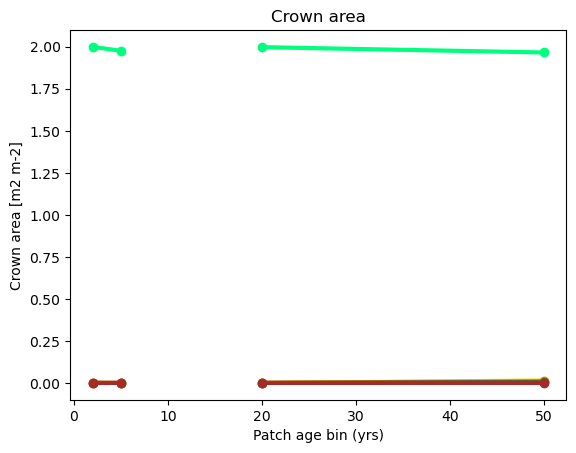

In [36]:
esm_viz.cca_by_patch_age(ds_end,
                         n_pfts = n_pfts,
                         pft_colors = pft_colors,
                         pft_names = pft_names,
                         canopy_crown_area = False)

### Canopy crown area by patch age

/glade/work/adamhb/opt/miniconda/envs/env4/lib/python3.8/site-packages/dask/core.py:119: RuntimeWarning: invalid value encountered in divide
  return func(*(_execute_task(a, cache) for a in args))
/glade/work/adamhb/opt/miniconda/envs/env4/lib/python3.8/site-packages/dask/core.py:119: RuntimeWarning: invalid value encountered in divide
  return func(*(_execute_task(a, cache) for a in args))
/glade/work/adamhb/opt/miniconda/envs/env4/lib/python3.8/site-packages/dask/core.py:119: RuntimeWarning: invalid value encountered in divide
  return func(*(_execute_task(a, cache) for a in args))
/glade/work/adamhb/opt/miniconda/envs/env4/lib/python3.8/site-packages/dask/core.py:119: RuntimeWarning: invalid value encountered in divide
  return func(*(_execute_task(a, cache) for a in args))
/glade/work/adamhb/opt/miniconda/envs/env4/lib/python3.8/site-packages/dask/core.py:119: RuntimeWarning: invalid value encountered in divide
  return func(*(_execute_task(a, cache) for a in args))


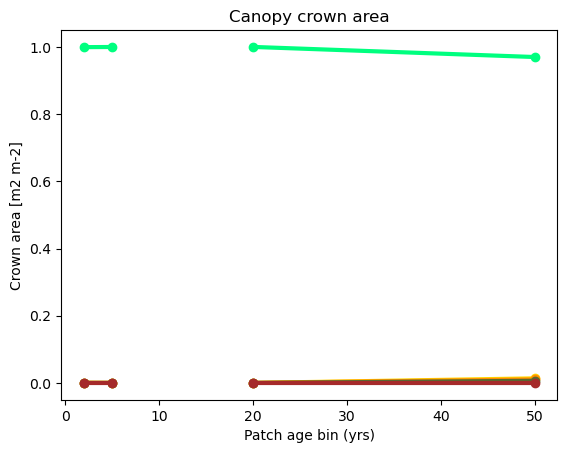

In [35]:
esm_viz.cca_by_patch_age(ds_end,n_pfts = n_pfts,
                          pft_colors = pft_colors,
                          pft_names = pft_names,canopy_crown_area = True)

## NPP

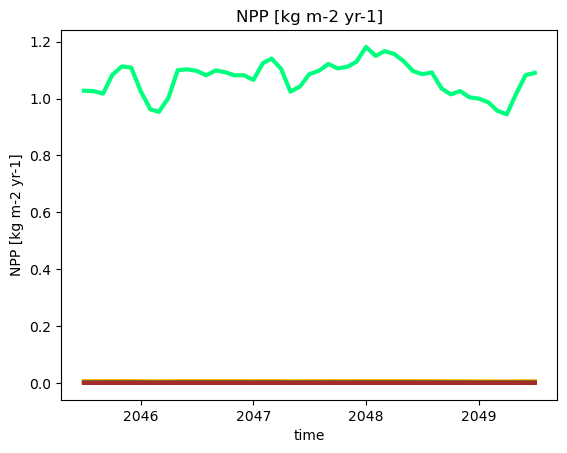

In [37]:
for p in range(n_pfts):
    mv_avg = ds_end.FATES_NPP_PF.isel(fates_levpft=p).rolling(time=12, center=True).mean()\
    * s_per_yr
    mv_avg.plot(x = "time", color = pft_colors[p],lw = 3)

plt.ylabel("NPP [kg m-2 yr-1]")
plt.title("NPP [kg m-2 yr-1]")
plt.show()

## Recruitment

### Per area [N ha-1]

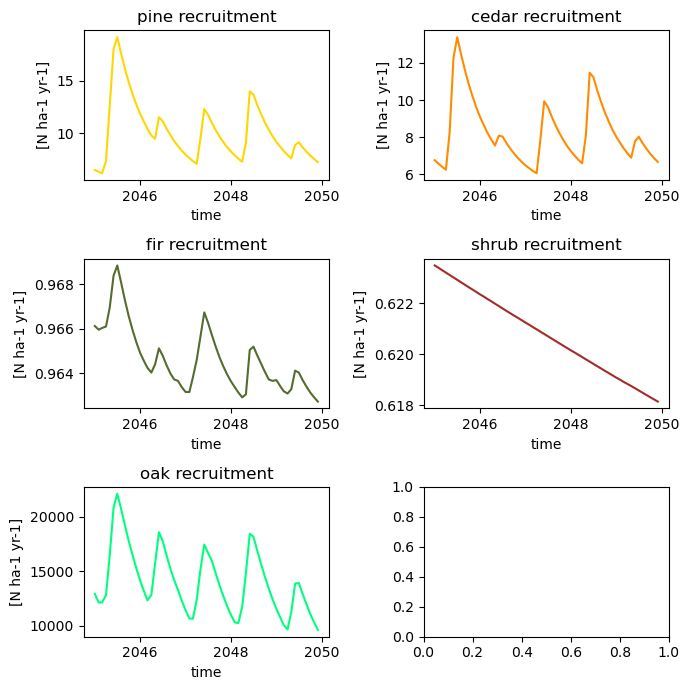

In [42]:
fig, axes = plt.subplots(ncols=2,nrows=3,figsize=(7,7))

for p,ax in zip(range(n_pfts),axes.ravel()):
    rec = ds_end.FATES_RECRUITMENT_PF.isel(fates_levpft=p) * m2_per_ha
    rec.plot(x = "time", color = pft_colors[p], ax=ax)
    ax.set_ylabel("[N ha-1 yr-1]")
    ax.set_title('{} recruitment'.format(pft_names[p]))
    
plt.tight_layout()

### Per unit basal area [N / m2 basal area]

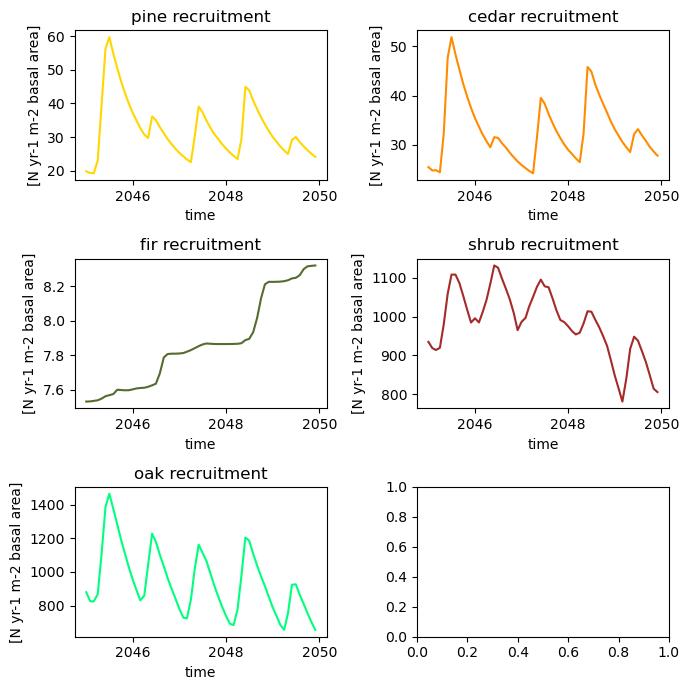

In [50]:
basal_area_pf = esm_tools.scpf_to_scls_by_pft(ds_end.FATES_BASALAREA_SZPF,ds_end)
basal_area_pf = basal_area_pf.sum(dim = "fates_levscls")

rec_per_cap = ds_end.FATES_RECRUITMENT_PF / basal_area_pf

fig, axes = plt.subplots(ncols=2,nrows=3,figsize=(7,7))

for p,ax in zip(range(n_pfts),axes.ravel()):
    rec = rec_per_cap.isel(fates_levpft=p)
    rec.plot(x = "time", color = pft_colors[p], ax=ax)
    ax.set_ylabel("[N yr-1 m-2 basal area]")
    ax.set_title('{} recruitment'.format(pft_names[p]))
    
plt.tight_layout()

## Seed bank

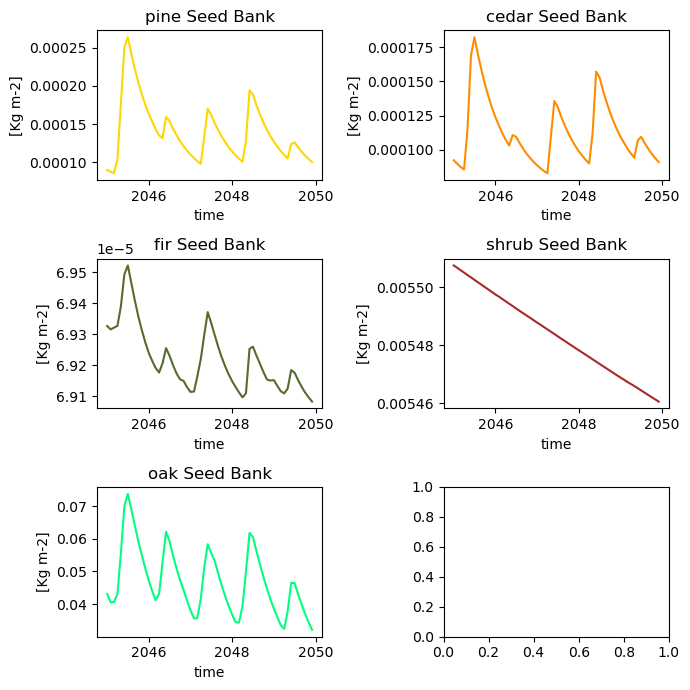

In [41]:
fig, axes = plt.subplots(ncols=2,nrows=3,figsize=(7,7))

for p,ax in zip(range(n_pfts),axes.ravel()):
    seed = ds_end.FATES_SEEDBANK_PF.isel(fates_levpft=p)
    seed.plot(x = "time", color = pft_colors[p], ax=ax)
    ax.set_ylabel("[Kg m-2]")
    ax.set_title('{} Seed Bank'.format(pft_names[p]))
    
plt.tight_layout()

## Fuel loads

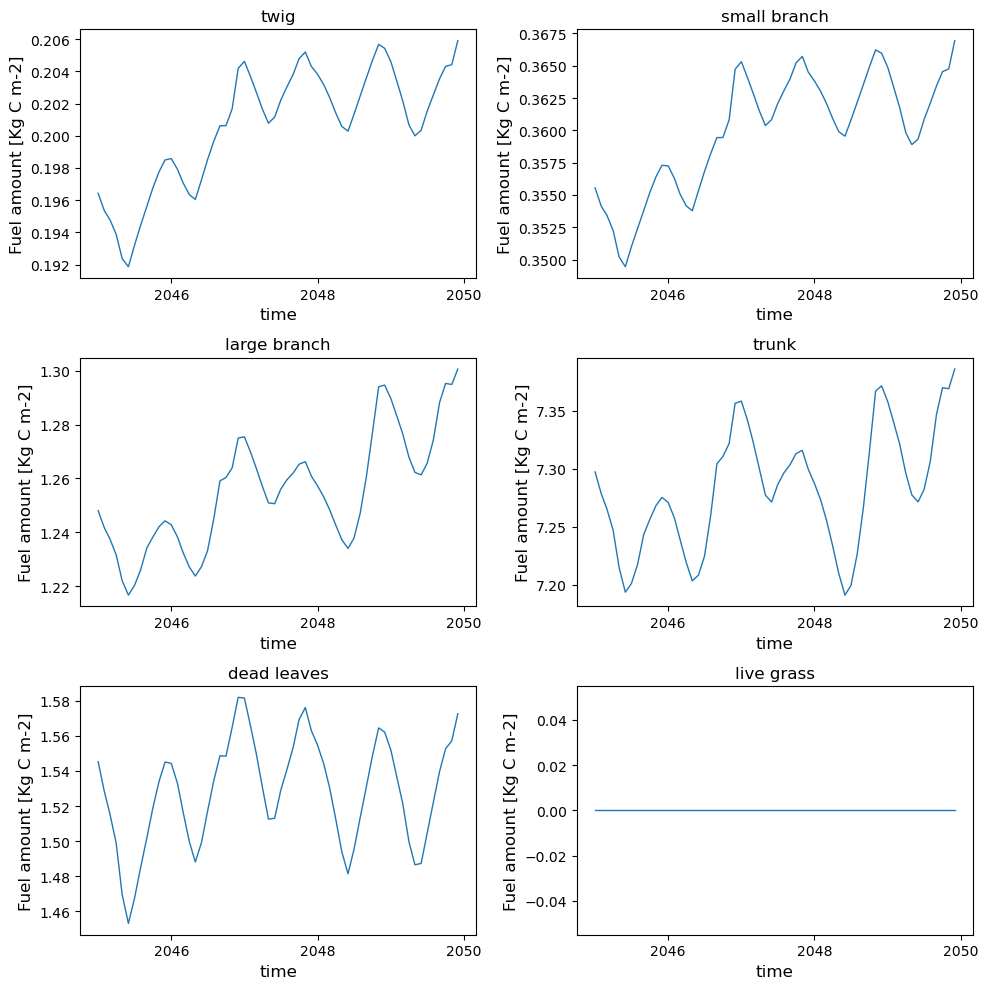

In [59]:
plt.rcParams.update({'axes.titlesize': 'large', 'axes.labelsize':'large'})

age_by_fuel = esm_tools.agefuel_to_age_by_fuel(ds_end.FATES_FUEL_AMOUNT_APFC,ds_end)
fates_fuel_amount_by_class = age_by_fuel.sum(dim = "fates_levage")

fig, axes = plt.subplots(ncols=2,nrows=3,figsize=(10,10), sharey = False)

fuel_class_names = ['twig','small branch','large branch','trunk','dead leaves','live grass']

for p,ax in zip(range(6),axes.ravel()):
    fates_fuel_amount_by_class.isel(fates_levfuel=p).plot(x = "time",lw = 1, ax = ax)
    ax.set_ylabel("Fuel amount [Kg C m-2]")
    ax.set_title(fuel_class_names[p])
    
plt.tight_layout()

### Combustible fuel total

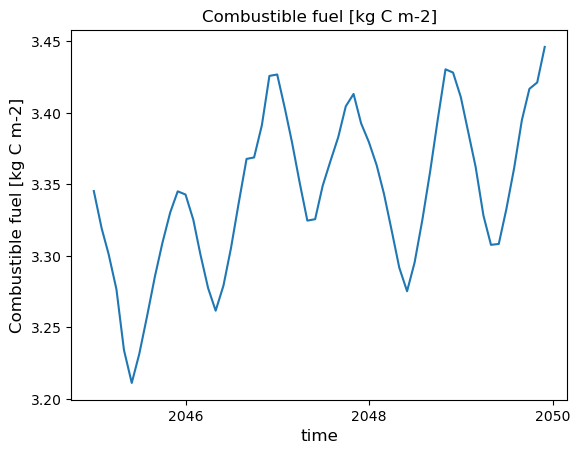

In [62]:
fates_trunk_fuel_amount = fates_fuel_amount_by_class.isel(fates_levfuel = 3)
fates_combustible_fuel_amount = fates_fuel_amount_by_class.sum(dim = "fates_levfuel") - fates_trunk_fuel_amount
fates_combustible_fuel_amount.plot()
plt.ylabel("Combustible fuel [kg C m-2]")
plt.title("Combustible fuel [kg C m-2]")
plt.show()

## Fuel moisture

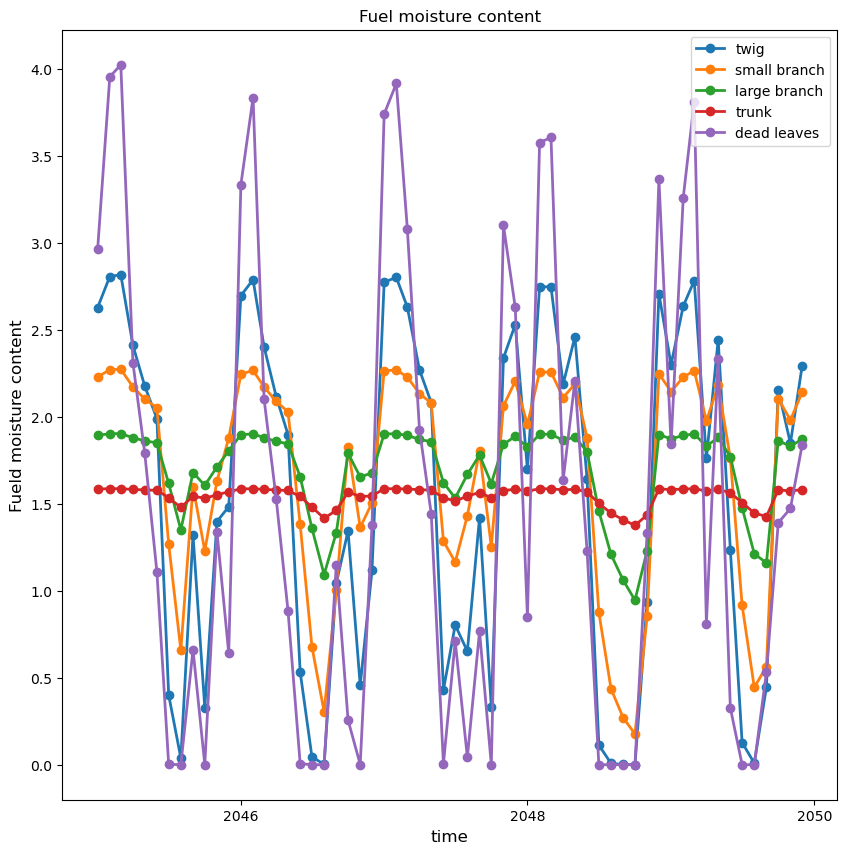

In [69]:
fig, ax = plt.subplots(figsize=(10, 10))
plt.rcParams.update({'axes.titlesize': 'large', 'axes.labelsize':'large'})

fuel_class_names = ['twig','small branch','large branch','trunk','dead leaves']

#plot pft-level basal area over time
for i,fc in enumerate(fuel_class_names):
    fmc = ds_end.FATES_FUEL_MOISTURE_FC.isel(fates_levfuel=i)
    fmc.plot(x = "time", label = fc,lw = 2, add_legend = True, marker = "o")

plt.legend()
plt.ylabel('Fueld moisture content', fontsize=12)
plt.title('Fuel moisture content')
plt.show()

## Soil moisture

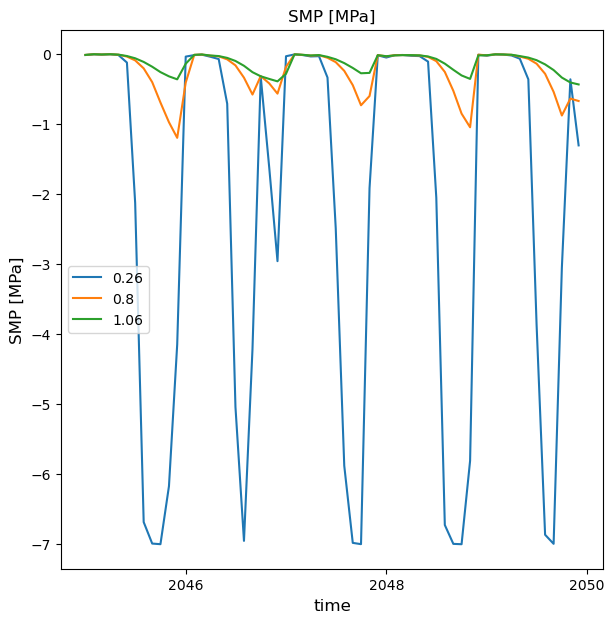

In [72]:
esm_viz.plot_smp(ds_end.SMP,ds_end,output_path=output_path_for_case)

# Full dataset

In [79]:
# define the history variables to read in
full_time_series_fields = [
          #have on to import these dimensions
          'FATES_SEED_PROD_USTORY_SZ',
          'FATES_VEGC_AP',
          #patches and cohorts
          'FATES_NPATCHES',
          'FATES_PATCHAREA_AP',
          'FATES_NPATCH_AP',
          #structure
          #'FATES_LAI_AP',
          #density
          'FATES_NPLANT_PF',
          'FATES_NPLANT_SZAPPF',
          'FATES_NPLANT_SZPF',
          #basal area
          'FATES_BASALAREA_SZPF',
          #crown_area
          'FATES_CANOPYCROWNAREA_PF',
          'FATES_CANOPYCROWNAREA_APPF',
          'FATES_CROWNAREA_APPF',
          'FATES_CROWNAREA_PF',
          #biomass
          #'FATES_VEGC_PF','FATES_VEGC_AP','FATES_VEGC_ABOVEGROUND','FATES_VEGC_ABOVEGROUND_SZPF',
          #growth
          #'FATES_DDBH_SZPF',
          #'FATES_DDBH_CANOPY_SZAP','FATES_DDBH_USTORY_SZAP',
          #mortality
          'FATES_MORTALITY_PF',
          #'FATES_MORTALITY_CANOPY_SZAP','FATES_MORTALITY_USTORY_SZAP',
          'FATES_MORTALITY_BACKGROUND_SZPF','FATES_MORTALITY_HYDRAULIC_SZPF','FATES_MORTALITY_CSTARV_SZPF',
          'FATES_MORTALITY_FIRE_SZPF','FATES_MORTALITY_CROWNSCORCH_SZPF',
          'FATES_MORTALITY_SENESCENCE_SZPF',
          #seed production and recruitment
          #GPP and NPP
          'FATES_NPP_PF','FATES_NPP_SZPF',
          #'FATES_AUTORESP_SZPF','FATES_MAINTAR_SZPF',
          #physical environment
          'SMP',
          #allocation
          #'FATES_STOREC_CANOPY_SZPF','FATES_STOREC_USTORY_SZPF',
          #fire
          'FATES_BURNFRAC','FATES_IGNITIONS','FATES_FIRE_INTENSITY_BURNFRAC',
          'FATES_FUEL_BULKD','FATES_FUEL_SAV',
          'FATES_FUEL_AMOUNT_AP',
          'FATES_FIRE_INTENSITY_BURNFRAC_AP',
          'FATES_BURNFRAC_AP',
          'FATES_NESTEROV_INDEX'
          ]

## Load the full dataset

In [82]:
ds = esm_tools.load_fates_output_data(model_output_root=model_output_root,
                            case_name = case_name,
                            years = years,
                            fields = full_time_series_fields,
                            inst_tag = inst_tag)

-- your data have been read in -- 


## Burned area

In [105]:
importlib.reload(esm_tools)
importlib.reload(esm_viz)

<module 'esm_viz' from '/glade/u/home/adamhb/Earth-System-Model-Tools/process_output/esm_viz.py'>

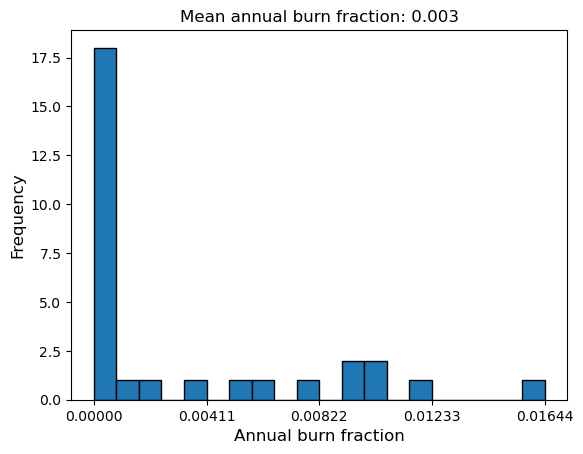

In [84]:
esm_viz.plot_mean_annual_burn_frac(ds,start_date=None,end_date=None)

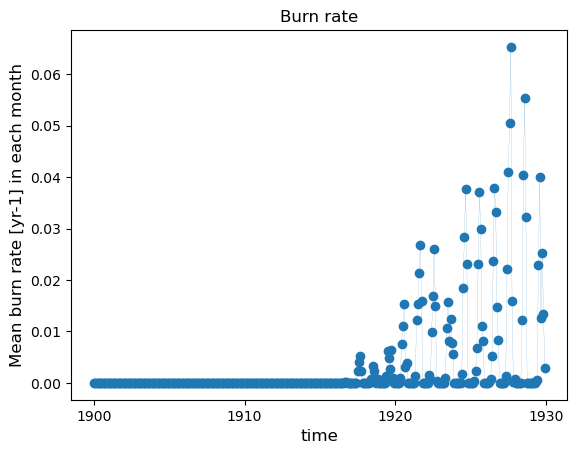

In [87]:
burnfrac = ds.FATES_BURNFRAC  * s_per_yr
burnfrac.plot(lw = 0.1, marker = "o")
plt.ylabel('Mean burn rate [yr-1] in each month', fontsize=12)
plt.title('Burn rate')
plt.show()

## Area-weighted fire intensity

/glade/work/adamhb/opt/miniconda/envs/env4/lib/python3.8/site-packages/dask/core.py:119: RuntimeWarning: invalid value encountered in divide
  return func(*(_execute_task(a, cache) for a in args))


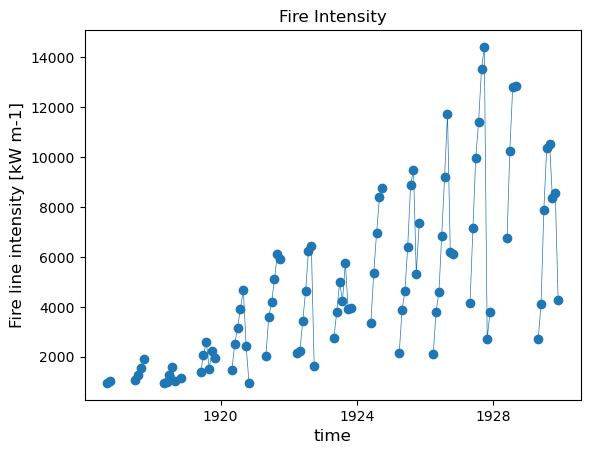

In [93]:
esm_viz.plot_area_weighted_fire_intensity(ds)

## Stem density

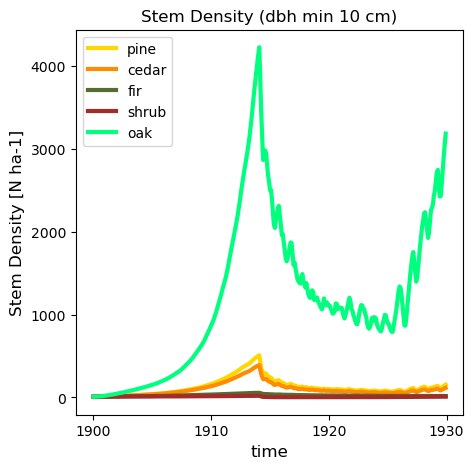

In [120]:
esm_viz.plot_array(ds.FATES_NPLANT_SZPF,
           xds = ds,
           n_pfts = n_pfts,
           pft_colors = pft_colors,
           pft_names = pft_names,
           title = "Stem Density" + " (dbh min " + str(10) + " cm)",
           ylabel = "Stem Density [N ha-1]",
           output_path = output_path_for_case,
           conversion = m2_per_ha,
           subplots = False,
           getData = False,
           dbh_min = 0)

## Basal area

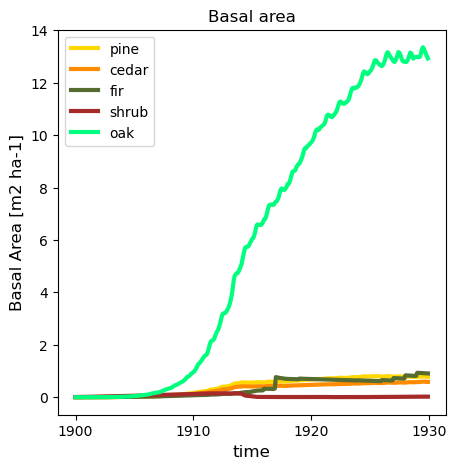

In [95]:
esm_viz.plot_array(ds.FATES_BASALAREA_SZPF,
           xds = ds,
           n_pfts = n_pfts,
           pft_colors = pft_colors,
           pft_names = pft_names,
           conversion = m2_per_ha,
           title = "Basal area",
           ylabel = "Basal Area [m2 ha-1]",
           output_path = output_path_for_case,
           subplots = False,
           getData = False,
           dbh_min = None)

## NPP

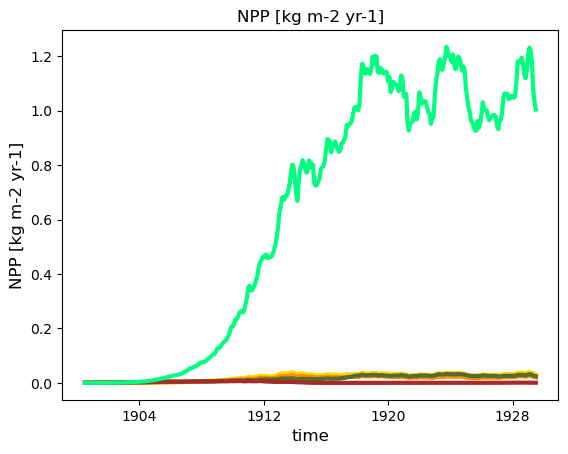

In [94]:
for p in range(n_pfts):
    mv_avg = ds.FATES_NPP_PF.isel(fates_levpft=p).rolling(time=12, center=True).mean()\
    * s_per_yr
    mv_avg.plot(x = "time", color = pft_colors[p],lw = 3)

plt.ylabel("NPP [kg m-2 yr-1]")
plt.title("NPP [kg m-2 yr-1]")
plt.show()

## NPP per unit basal area

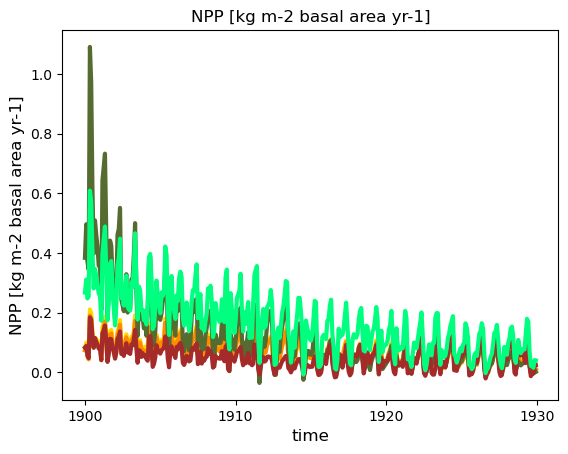

In [102]:
basal_area_pf = esm_tools.scpf_to_scls_by_pft(ds.FATES_BASALAREA_SZPF,ds)
basal_area_pf = basal_area_pf.sum(dim = "fates_levscls") * m2_per_ha

npp = ds.FATES_NPP_PF * s_per_yr

NPP_per_unit_ba = npp / basal_area_pf

for p in range(n_pfts):
    #mv_avg = NPP_per_unit_ba.isel(fates_levpft=p).rolling(time=12, center=True).mean()\
    #* s_per_yr
    #basal_area_pf.isel(fates_levpft=p).plot(x = "time", color = pft_colors[p],lw = 3)
    NPP_per_unit_ba.isel(fates_levpft=p).plot(x = "time", color = pft_colors[p],lw = 3)
    
    #mv_avg.plot(x = "time", color = pft_colors[p],lw = 3)

plt.ylabel("NPP [kg m-2 basal area yr-1]")
plt.title("NPP [kg m-2 basal area yr-1]")
plt.show()

## Per capita mortality rates

In [106]:
yrs_per_month = 1/12

#Plot mortality rates
mort_types = (ds.FATES_MORTALITY_PF, ds.FATES_MORTALITY_BACKGROUND_SZPF,
              ds.FATES_MORTALITY_HYDRAULIC_SZPF, ds.FATES_MORTALITY_CSTARV_SZPF,
              ds.FATES_MORTALITY_FIRE_SZPF)

# Get per capita mortality rates
m_total, m_back, m_hydr, m_cstarv, m_fire = map(functools.partial(esm_tools.per_capita_rate,
                                           xds = ds, unit_conversion = yrs_per_month),mort_types)
morts = (m_total, m_back, m_hydr, m_cstarv, m_fire)

mort_titles = ["Total Mortality Rate","Background Mortality Rate","Hydraulic Failure Mortality",
"Carbon Starvation Mortality","Fire Mortality"]

for i in range(len(mort_titles)):
    esm_viz.plot_array(xarr=morts[i],xds=ds,n_pfts=n_pfts,
                       pft_colors=pft_colors,
                       pft_names = pft_names,
                       title = mort_titles[i],
                       ylabel='[N per capita month-1]',
                       output_path=output_path_for_case)

## Per-area mortality rates

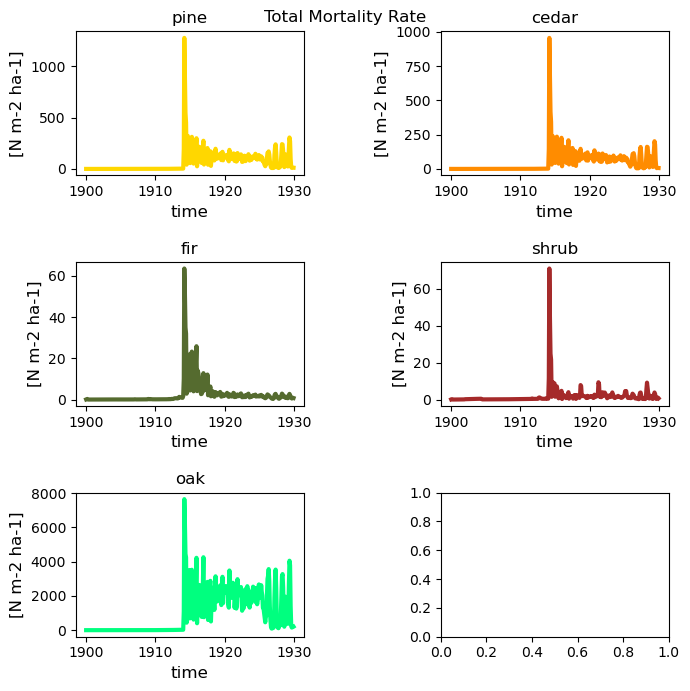

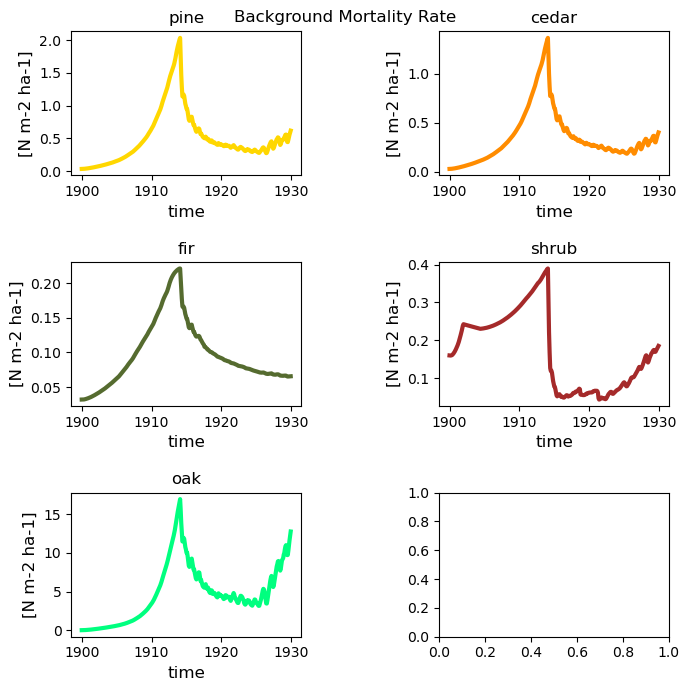

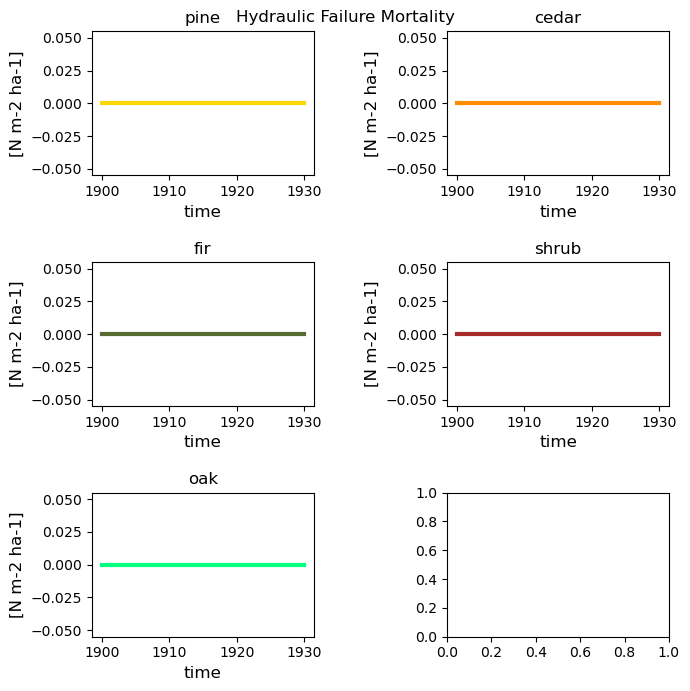

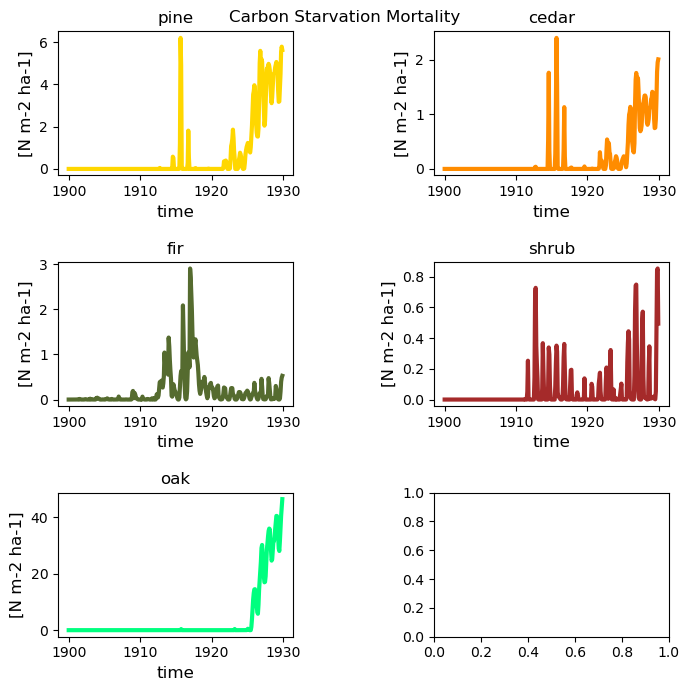

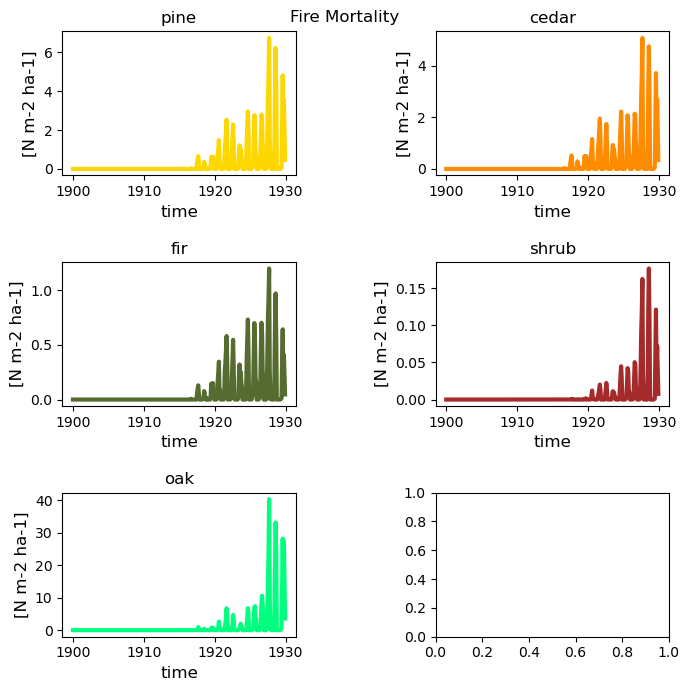

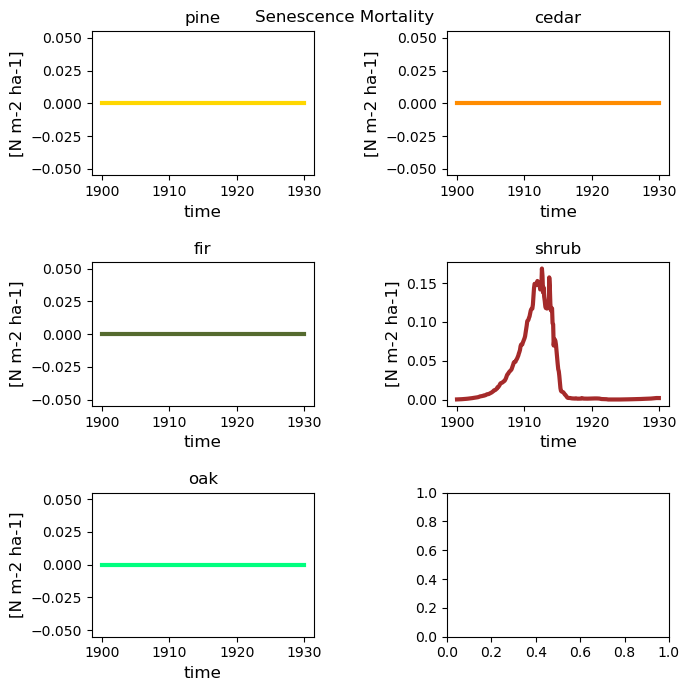

In [123]:
morts = (ds.FATES_MORTALITY_PF, ds.FATES_MORTALITY_BACKGROUND_SZPF,
              ds.FATES_MORTALITY_HYDRAULIC_SZPF, ds.FATES_MORTALITY_CSTARV_SZPF,
              ds.FATES_MORTALITY_FIRE_SZPF,ds.FATES_MORTALITY_SENESCENCE_SZPF)

mort_titles = ["Total Mortality Rate","Background Mortality Rate","Hydraulic Failure Mortality",
"Carbon Starvation Mortality","Fire Mortality","Senescence Mortality"]

for i in range(len(mort_titles)):
    esm_viz.plot_array(xarr=morts[i],xds=ds,n_pfts=n_pfts,
                       pft_colors=pft_colors,
                       pft_names = pft_names,
                       title = mort_titles[i],
                       ylabel='[N m-2 ha-1]',
                       output_path=output_path_for_case,
                       conversion=m2_per_ha,
                       subplots=True)